# 量子機械学習
Kifumi Numata, IBM Quantum (Jun 26, 2023)

## QSVM (Quantum Support Vector Machine)を使ったMNIST分類

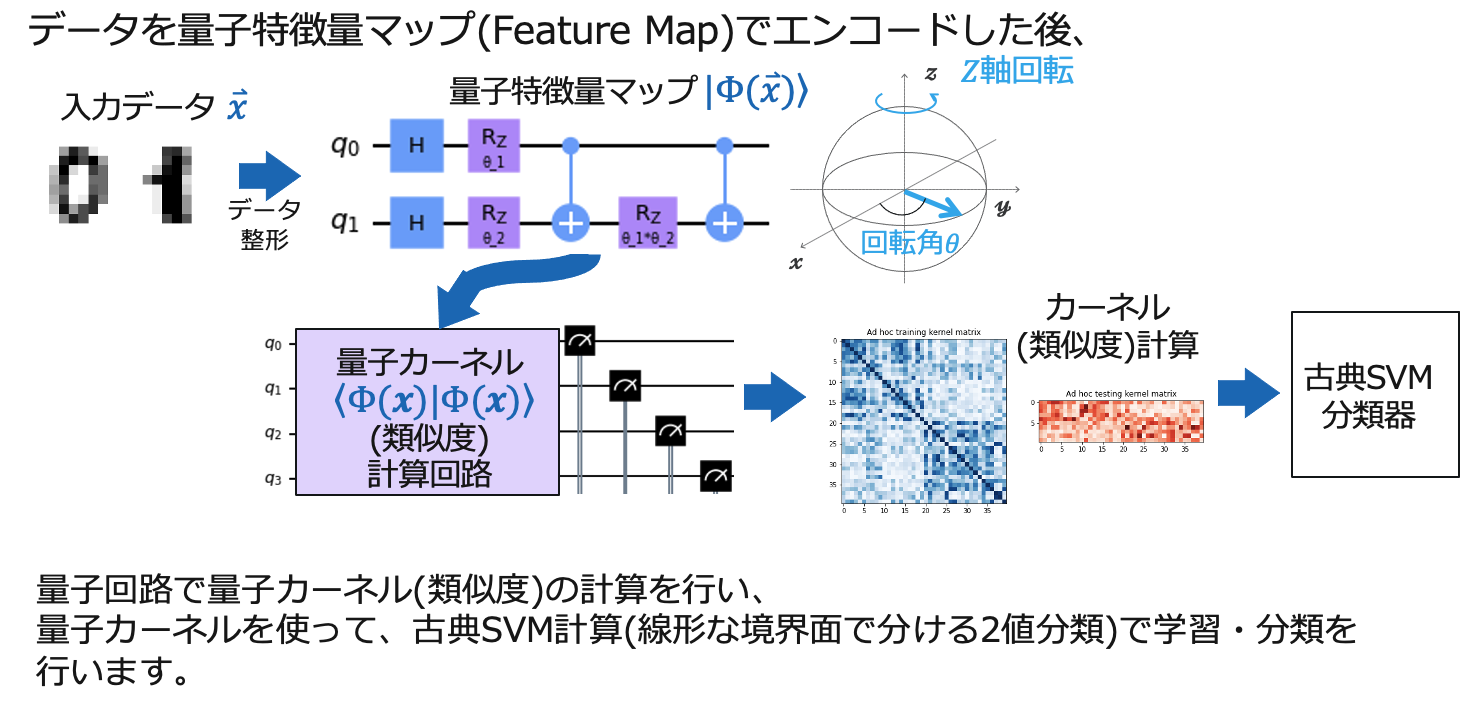

必要なライブラリーを導入します。

In [1]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split # データ分割
from sklearn.svm import SVC # SVM Classification(SVM分類)
from sklearn.decomposition import PCA # Principal component analysis(主成分分析)
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 標準化、正規化のスケール変換

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel

データを用意します。このデータセットには、合計360個のデータポイントが含まれています。各データポイントは、8×8の数字の画像で、配列に折りたたまれており、各要素は0（白）から16（黒）までの整数でです。

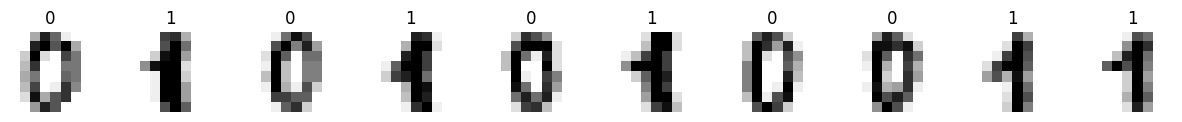

In [2]:
# 数字データセットの読み込み
digits = datasets.load_digits(n_class=2)

# '0' と'1'の例のプロット
fig, axes = plt.subplots(1, 10, figsize=(15, 15), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.5, wspace=0.5))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(digits.target[i])

古典的な分類と同様に、データセットを学習用（40個）とテスト用（10個）のサンプルに分割し、正規化する必要があります。このデータセットを量子分類に用いるためには、範囲を-1から1の間にスケーリングし、次元を使用したい量子ビットの数（4）に縮小する必要があります。

In [3]:
# データセットの分割
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.4, random_state=22)

# 次元削除
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# 正規化
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# スケーリング
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# 選択
train_size = 40
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 10
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [4]:
# 一つ目のデータをそれぞれ表示
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.84125996 -0.08883315 -0.41289909 -0.08403989] 0
[ 0.41456664 -0.7486731   0.74168091  0.32496914] 1


In [5]:
# 学習用データのラベルを表示
print(label_train)

[0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1
 1 0 0]


### 特徴量マップの例
量子特徴量マップの例をみてみます。量子回路の回転角の部分がデータ(特徴量)を入れるパラメーターです。

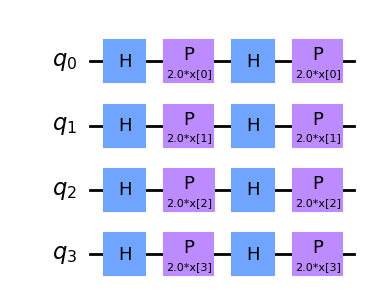

In [6]:
# 4特徴量、深さ2のZFeatureMap
map_z = ZFeatureMap(feature_dimension=4, reps=2)
map_z.decompose().draw('mpl')

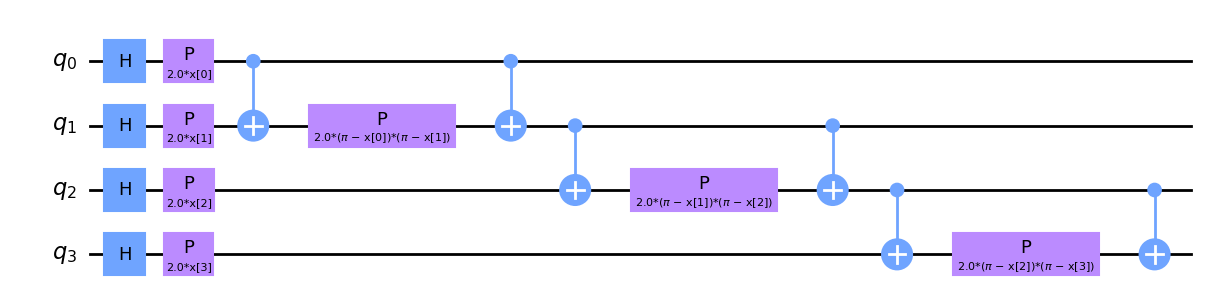

In [7]:
# 4特徴量、深さ1、線形量子もつれのZZFeatureMap
map_zz = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

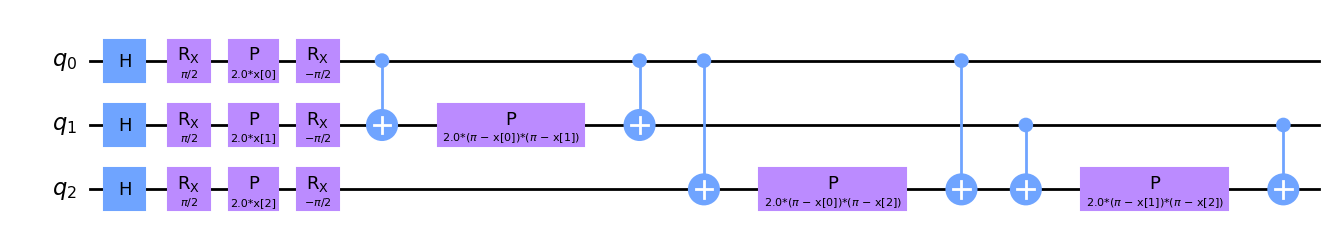

In [8]:
# 3特徴量、深さ1でY、ZZを使ったPauliFeatureMap
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

### 量子カーネルの計算

ZZFeatureMapを使って、学習データの0個目と1個目のデータについて、量子カーネルを計算する量子回路を作成し、実際に計算してみます。この値は、二つの量子状態のFidelity(忠実度)ともいいます。

In [9]:
print(sample_train[0])
print(sample_train[1])

[-0.84125996 -0.08883315 -0.41289909 -0.08403989]
[-0.63560347 -0.29571254 -0.49227085  0.39130638]


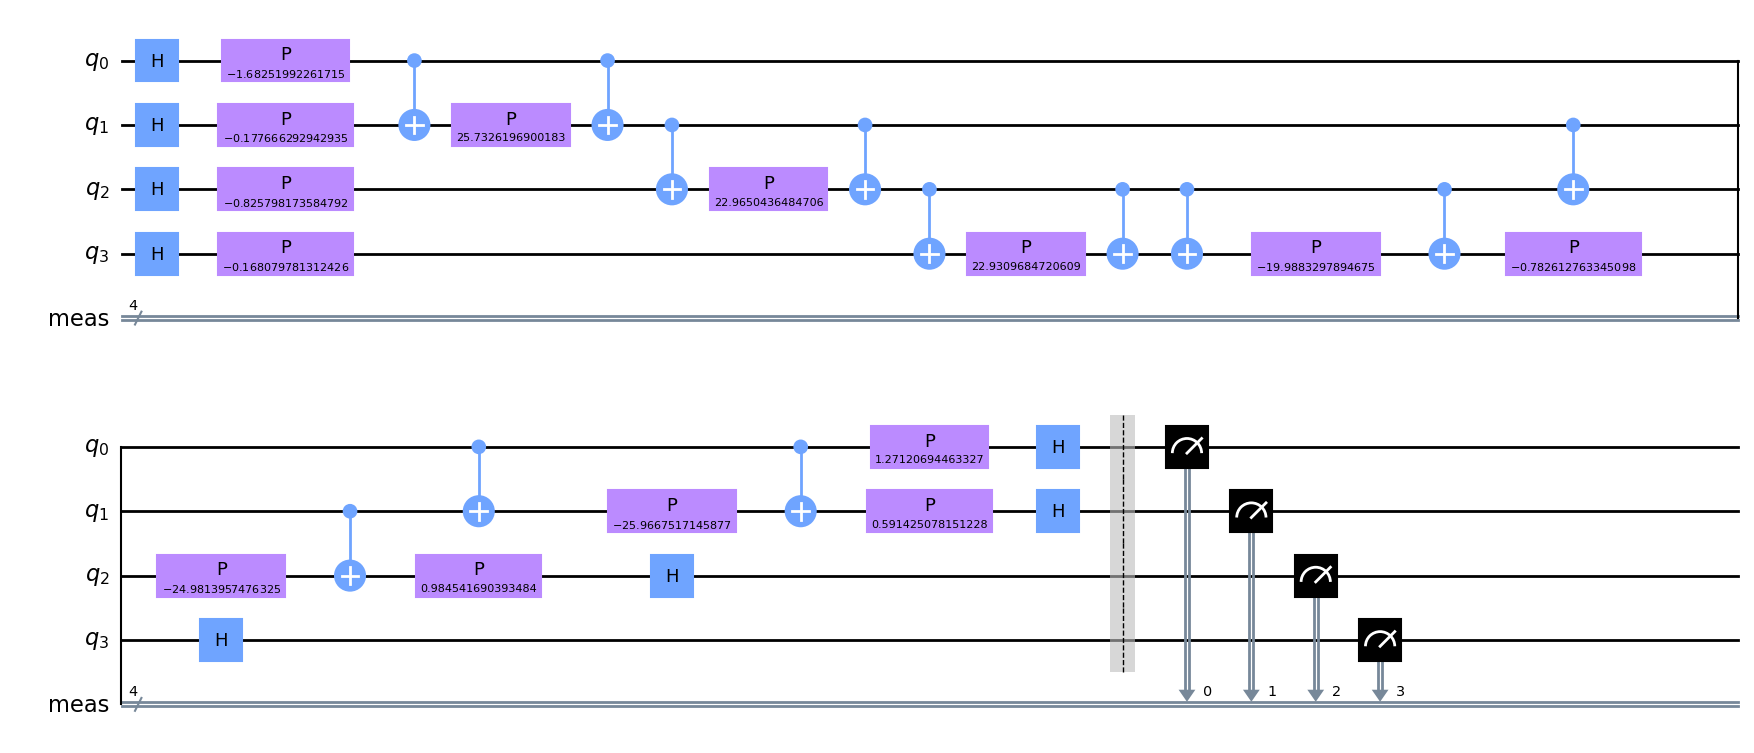

In [10]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='linear')
qc_1 = zz_map.bind_parameters(sample_train[0])
qc_2 = zz_map.bind_parameters(sample_train[1])
fidelity_circuit = qc_1.copy()
fidelity_circuit.append(qc_2.inverse().decompose(), range(fidelity_circuit.num_qubits))
fidelity_circuit.measure_all()
fidelity_circuit.decompose().draw('mpl')

In [11]:
# Use Aer's qasm_simulator
from qiskit import Aer
backend_sim = Aer.get_backend('qasm_simulator')

from qiskit import transpile
job_sim = backend_sim.run(transpile(fidelity_circuit, backend_sim), shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(fidelity_circuit)

In [12]:
counts['0000']/sum(counts.values())

0.01171875

### 量子カーネル計算
``FidelityQuantumKernel`` クラスをセットアップし、  `ZZFeatureMap`を用いて量子カーネル行列を計算します。ここでは、 ``Sampler`` primitiveと、状態間のオーバーラップ(二つの状態の重なり具合)を計算する ``ComputeUncompute`` fidelityを使用します。

In [13]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='linear')
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
zz_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=zz_map)

学習データとテストデータについてカーネル行列を計算します。

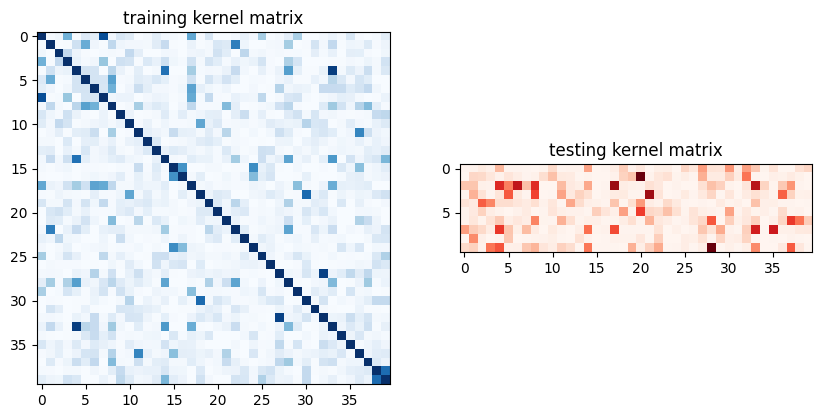

In [14]:
# 学習データ同士のカーネル行列計算(40x40)
matrix_train = zz_kernel.evaluate(x_vec=sample_train)

# 学習データとテストデータとのカーネル行列計算(40x10)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

# カーネル行列の表示
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

古典SVM分類器を使って学習し、テストデータのラベルを予測し、学習率を確認します。

In [15]:
zz_svc = SVC(kernel='precomputed') #事前に計算したカーネルを使用
zz_svc.fit(matrix_train, label_train) #学習データ同士のカーネルとラベルを使って学習

#学習データとテストデータとのカーネル行列を使ってテストデータのラベルを予測
label_predict = zz_svc.predict(matrix_test)
print(label_predict, label_test)

[1 1 0 1 1 1 0 0 1 0] [1 1 0 1 1 1 0 0 1 0]


In [16]:
#学習率を表示
zz_score = zz_svc.score(matrix_test, label_test) 
print(f'Precomputed kernel classification test score: {zz_score}')

Precomputed kernel classification test score: 1.0


In [17]:
import qiskit.tools.jupyter
%qiskit_version_table